In [1]:
print("Time Series ARIMA script begin.")
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as api
#import statsmodels.tsa as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

Time Series ARIMA script begin.


In [2]:
#declarations: sensor, year, model parameters (threshold and (p, d, q))
sensor = 'ODO' #options: 'ODO', 'pH', 'SpCond', 'Stage', 'TurbMed', 'WaterTemp_EXO'
year = '2015' #options: '2015', '2016', '2017', '2018', '2019'
threshold = 0.5
p = 1
d = 0
q = 1
#Tanner's choice parameters:
# ODO threshold = 0.5, (p, d, q) = (1, 0, 1)
# pH threshold = 0.06, (p, d, q) = (1, 0, 4)
# SpCond threshold = 12, (p, d, q) = (1, 1, 2)
# Stage threshold = 15, (p, d, q) = (1, 0, 1)
# TurbMed threshold = ?, (p, d, q) = (?, ?, ?)
# WaterTemp_EXO threshold = ?, (p, d, q) = (?, ?, ?)


In [5]:
#data file structure 
dir_raw = "RawData"
dir_corr = "CorrectedData"
file_list = os.listdir(dir_raw)
# print(file_list)
#Get corrected/labeled data
print('\n\n\nImporting corrected data...\n')
df_lbld = pd.read_csv(dir_corr + "/LR_Mendon_AA_" + sensor + "_SourceID_1_QC_1.csv", header=0, index_col=0, parse_dates=True, infer_datetime_format=True)
print(df_lbld.head())




Importing corrected data...

                     UTCOffset          DateTimeUTC    ODO CensorCode  \
LocalDateTime                                                           
2014-01-01 00:00:00       -7.0  2014-01-01 07:00:00  10.75         nc   
2014-01-01 00:15:00       -7.0  2014-01-01 07:15:00  10.75         nc   
2014-01-01 00:30:00       -7.0  2014-01-01 07:30:00  10.75         nc   
2014-01-01 00:45:00       -7.0  2014-01-01 07:45:00  10.73         nc   
2014-01-01 01:00:00       -7.0  2014-01-01 08:00:00  10.74         nc   

                    QualifierCode  
LocalDateTime                      
2014-01-01 00:00:00           NaN  
2014-01-01 00:15:00           NaN  
2014-01-01 00:30:00           NaN  
2014-01-01 00:45:00           NaN  
2014-01-01 01:00:00           NaN  


In [6]:
normal_lbl = df_lbld.QualifierCode.isnull()
file_ind = 0
if '2015' == year:
    normal_lbl = normal_lbl['2015-01-01 00:00:00':'2015-12-31 23:45:00']
    file_ind = 1
elif '2016' == year:
    normal_lbl = normal_lbl['2016-01-01 00:00:00':'2016-12-31 23:45:00']
    file_ind = 2
elif '2017' == year:
    normal_lbl = normal_lbl['2017-01-01 00:00:00':'2017-12-31 23:45:00']
    file_ind = 0
elif '2018' == year:
    normal_lbl = normal_lbl['2018-01-01 00:00:00':'2018-12-31 23:45:00']
    file_ind = 3
elif '2019' == year:
    normal_lbl = normal_lbl['2019-01-01 00:00:00':'2019-12-31 23:45:00']
    file_ind = 4

print('\n\n\nImporting raw data...\n')
df = pd.read_csv(dir_raw + "/" + file_list[file_ind], header=0, index_col=0, parse_dates=True, infer_datetime_format=True)
print(df.head())




Importing raw data...

                     UTCOffset          DateTimeUTC   BGA  BattVolt  \
LocalDateTime                                                         
2015-01-01 00:00:00       -7.0  2015-01-01 07:00:00  0.03     12.66   
2015-01-01 00:15:00       -7.0  2015-01-01 07:15:00  0.02     12.66   
2015-01-01 00:30:00       -7.0  2015-01-01 07:30:00  0.02     12.65   
2015-01-01 00:45:00       -7.0  2015-01-01 07:45:00  0.03     12.64   
2015-01-01 01:00:00       -7.0  2015-01-01 08:00:00  0.01     12.63   

                     Chlorophyll  Door_Tot  EXOTime  EXOVolt  Nitrate-N  \
LocalDateTime                                                             
2015-01-01 00:00:00         0.53       0.0  64503.0    11.88    -9999.0   
2015-01-01 00:15:00         0.31       0.0  70003.0    11.88    -9999.0   
2015-01-01 00:30:00         0.43       0.0  71502.0    11.88    -9999.0   
2015-01-01 00:45:00         0.38       0.0  73003.0    11.88    -9999.0   
2015-01-01 01:00:00       

In [7]:
#generate series from dataframe - time indexed values
srs = pd.Series(df[sensor])
model = ARIMA(srs, order=(p,d,q))
model_fit = model.fit(disp=0)

print('\n\n')
print(model_fit.summary())
# model_fit.plot_predict(dynamic=False)

/opt/anaconda3/envs/env6830/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)





                              ARMA Model Results                              
Dep. Variable:                    ODO   No. Observations:                34754
Model:                     ARMA(1, 1)   Log Likelihood               19880.915
Method:                       css-mle   S.D. of innovations              0.137
Date:                Tue, 07 Apr 2020   AIC                         -39753.829
Time:                        09:27:57   BIC                         -39720.005
Sample:                             0   HQIC                        -39743.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3937      0.277     33.906      0.000       8.851       9.937
ar.L1.ODO      0.9978      0.000   2773.466      0.000       0.997       0.998
ma.L1.ODO     -0.1397      0.004    -32.776      

In [8]:
#find residual errors
residuals = pd.DataFrame(model_fit.resid)
print('\n\nresiduals description:')
print(residuals.describe())



residuals description:
                  0
count  34754.000000
mean      -0.000092
std        0.137163
min      -11.971626
25%       -0.048658
50%        0.003161
75%        0.038025
max       10.456423


In [9]:
# determine anomalies
anomDetn = np.abs(residuals) > threshold # gives bools
anomDetn[0][0] = False # correct 1st value
print('\nratio of detections: %f' % ((sum(anomDetn[0])/len(srs))*100), '%')


ratio of detections: 0.086321 %


In [12]:
#determine labeled anomalies
anomaly_count = 0
anomaly_events = []
anomaly_events.append(0)
for i in range(1, len(normal_lbl)):
    if not(normal_lbl[i]):
        if normal_lbl[i-1]:
            anomaly_count += 1
            anomaly_events[i-1] = anomaly_count
        anomaly_events.append(anomaly_count)
    else:
        if not(normal_lbl[i-1]):
            anomaly_events.append(anomaly_count)
        else:
            anomaly_events.append(0)


In [13]:
anomLbl = pd.DataFrame(data=anomaly_events, index=normal_lbl.index)

#fix missing values
anomDetn = anomDetn.reindex(anomLbl.index)
anomDetn[anomDetn.isnull()] = True

#determine detectedions
det_count = 0
det_events = []
det_events.append(0)
for i in range(1, len(anomDetn)):
    if anomDetn[0][i]: #is a detection
        if not(anomDetn[0][i-1]): #prev is not detection
            det_count += 1
            det_events[i-1] = det_count
        det_events.append(det_count)#append detection number
    else: #is not a detection
        if anomDetn[0][i-1]: #prev is a detection
              det_events.append(det_count)# append det number
        else:
              det_events.append(0) #not a detection


anomDetns = pd.DataFrame(data=det_events, index=normal_lbl.index)

In [21]:
anomDetns

,0
LocalDateTime,
2015-01-01 00:00:00,0
2015-01-01 00:15:00,0
2015-01-01 00:30:00,0
2015-01-01 00:45:00,0
2015-01-01 01:00:00,0
...,...
2015-12-31 22:45:00,0
2015-12-31 23:00:00,0
2015-12-31 23:15:00,0


In [14]:
#generate lists of detected anomalies and valid detections
detected_anomalies = [0]
valid_detections = [0]
for i in range(0, len(anomDetn)):
    if anomDetn[0][i]: # anomaly detected
        if 0!=anomLbl[0][i]: # labeled as anomaly
            if not(detected_anomalies[-1] == anomLbl[0][i]):#if not already in list of detected anomalies
                detected_anomalies.append(anomLbl[0][i])
            if not(valid_detections[-1] == anomDetns[0][i]):#if not already in list of valid detections
                valid_detections.append(anomDetns[0][i])


In [17]:
detected_anomalies.pop(0)
valid_detections.pop(0)
invalid_detections = []
det_ind = 0
for i in range(1, max(anomDetns[0])):
    if (det_ind < len(valid_detections)):
        if i == valid_detections[det_ind]:
            det_ind += 1
        else:
            invalid_detections.append(i)

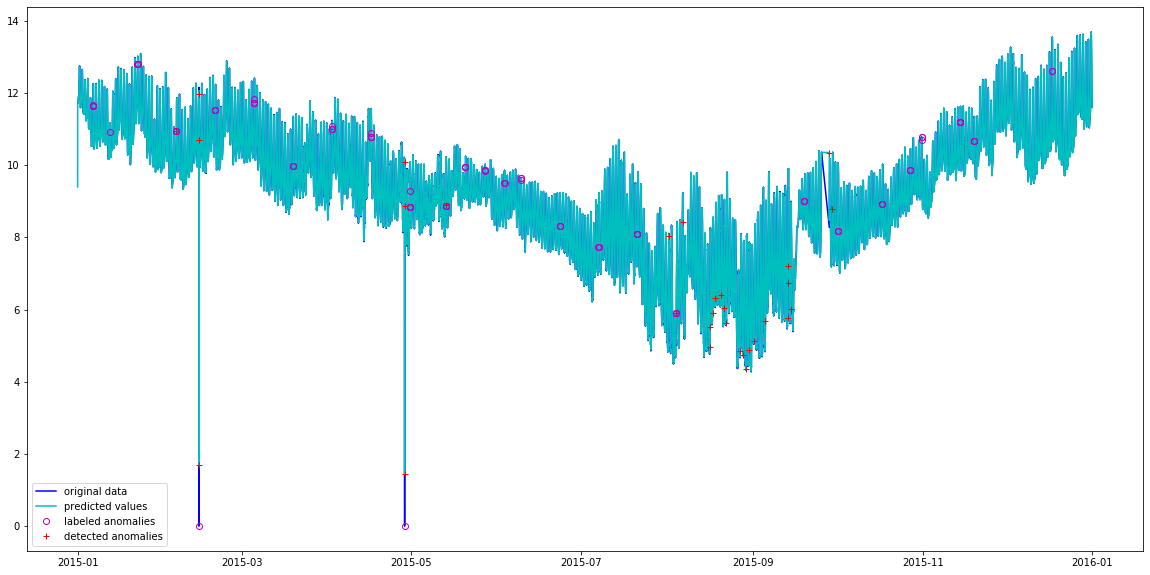




Script report:

Sensor: ODO
Year: 2015
Parameters: ARIMA(1, 0, 1), Threshold = 0.500000
PPV = 0.863760
NPV = 0.996106
Acc = 0.994720
TP  = 317
TN  = 34538
FP  = 50
FN  = 135

Time Series ARIMA script end.


In [22]:
#generate plots
anom_srs = model_fit.predict()
# fig = plt.figure()
# ax1 = fig.add_subplot(1,1,1)
# ax1.plot(srs[anomDetn[0]], 'r+', label='anomalies')
# fig.plot(srs[anomDetn[0]], 'r+')
# model_fit.plot_predict(dynamic=False)
# plt.plot(srs[anomDetn[0]], 'r+', label='anomalies')
# ax1.set_ylabel('anomalies, forcast, Specific Conductance')
# legend = ax1.legend()

# odo_srs = srs
# odo_anom_srs = anom_srs
# odo_normal_lbl = normal_lbl
# odo_anomDetn = anomDetn

# ph_srs = srs
# ph_anom_srs = anom_srs
# ph_normal_lbl = normal_lbl
# ph_anomDetn = anomDetn

# spc_srs = srs
# spc_anom_srs = anom_srs
# spc_normal_lbl = normal_lbl
# spc_anomDetn = anomDetn

# fig = plt.figure(figsize=(10,10))

# ax1 = fig.add_subplot(3, 1, 1)
# ax1.plot(odo_srs, 'b', label='original data')
# ax1.plot(odo_anom_srs, 'c', label='predicted values')
# ax1.plot(odo_srs[~odo_normal_lbl], 'mo', mfc='none', label='labeled anomalies')
# ax1.plot(odo_anom_srs[odo_anomDetn[0]], 'r+', label='detected anomalies')
# # ax1.legend()
# ax1.ylabel('Dissolved Oxygen')

# ax2 = fig.add_subplot(3, 1, 3)
# ax2.plot(ph_srs, 'b', label='original data')
# ax2.plot(ph_anom_srs, 'c', label='predicted values')
# ax2.plot(ph_srs[~ph_normal_lbl], 'mo', mfc='none', label='labeled anomalies')
# ax2.plot(ph_anom_srs[ph_anomDetn[0]], 'r+', label='detected anomalies')
# # ax2.legend()
# ax2.ylabel('pH')

# ax3 = fig.add_subplot(3, 1, 2)
# ax3.plot(spc_srs, 'b', label='original data')
# ax3.plot(spc_anom_srs+spc_srs, 'c', label='predicted values')
# ax3.plot(spc_srs[~spc_normal_lbl], 'mo', mfc='none', label='labeled anomalies')
# ax3.plot(spc_anom_srs[spc_anomDetn[0]]+spc_srs[spc_anomDetn[0]], 'r+', label='detected anomalies')
# # ax3.legend()
# ax3.ylabel('Specific Conductance')
fig = plt.figure(figsize=(20,10))
plt.plot(srs, 'b', label='original data')
plt.plot(anom_srs, 'c', label='predicted values')
plt.plot(srs[~normal_lbl], 'mo', mfc='none', label='labeled anomalies')
plt.plot(anom_srs[anomDetn[0]], 'r+', label='detected anomalies')
plt.legend()
plt.show()

#generate confusion matrix
TruePositives = sum(anomLbl[0].value_counts()[detected_anomalies])
FalseNegatives= len(anomDetn) - anomLbl[0].value_counts()[0] - TruePositives
FalsePositives= sum(anomDetns[0].value_counts()[invalid_detections])
TrueNegatives = len(anomDetn) - TruePositives - FalseNegatives - FalsePositives

PPV = TruePositives/(TruePositives+FalsePositives)
NPV = TrueNegatives/(TrueNegatives+FalseNegatives)
ACC = (TruePositives+TrueNegatives)/len(anomDetn)
# ACC = (TruePositives+TrueNegatives)/(TruePositives+TrueNegatives+FalsePositives+FalseNegatives)

print('\n\n\nScript report:\n')
print('Sensor: ' + sensor)
print('Year: ' + year)
print('Parameters: ARIMA(%i, %i, %i), Threshold = %f' %(p, d, q, threshold))
print('PPV = %f' % PPV)
print('NPV = %f' % NPV)
print('Acc = %f' % ACC)
print('TP  = %i' % TruePositives)
print('TN  = %i' % TrueNegatives)
print('FP  = %i' % FalsePositives)
print('FN  = %i' % FalseNegatives)

print("\nTime Series ARIMA script end.")